In [2]:
!python -V
import numpy as np
import seaborn as sns
import time
from typing import Callable

rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

*Note: I had originally written this code unparallelized, so the run times for Question 1 are abysmally long. The code works fine, but ideally I would parallelize everything. Questions 2 and 3 are parallelized, and under ideal conditions I would rewrite this code, however my Week 4 has been extremely busy.*

## (a)

For a general Ito process $dX_t = a(t, X_t) dt + b(t, X_t) dW_t$, we recall that the Milstein scheme is given by

$$
\hat{X}_{n+1} = \hat{X}_n + a(t_n, \hat{X}_n) \Delta t + b(t_n, \hat{X}_n) \Delta W_{n+1} + b_x (t_n, \hat{X}_n) b(t_n, \hat{X}_n) \left( \frac{(\Delta W_{n+1})^2 - \Delta t}{2} \right)
$$
Where $\Delta W_{n} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Delta t)$

Therefore, for $dV_t = \kappa (\theta - V_t) dt + \eta \sqrt{V_t} dW_t$ we have that its Milstein scheme is given by

$$
    \begin{align*}
        \hat{V}_{n+1} &= \hat{V}_n + \kappa (\theta - \hat{V}_n) \Delta t + \eta \sqrt{\hat{V}_n} \Delta W_{n+1} + \frac{\eta}{2 \sqrt{\hat{V}_n}} \cdot \eta \sqrt{\hat{V}_n} \left( \frac{(\Delta W_{n+1})^2 - \Delta t}{2} \right) \\
        &= \hat{V}_n + \kappa (\theta - \hat{V}_n) \Delta t + \eta \sqrt{\hat{V}_n} \Delta W_{n+1} + \frac{\eta^2}{4} \left( (\Delta W_{n+1})^2 - \Delta t \right)
    \end{align*} 
$$

## (b)

In [15]:
def euler_euler_path(
    *,
    dt: float,
    T: float,
    r: float,
    kappa: float,
    theta: float,
    eta: float,
    s0: float,
    v0: float,
    rho: float
) -> tuple[np.ndarray, np.ndarray]:
    '''
    Simulates one path by performing Euler-Mayurama for both St, Vt.
    Returns a tuple (St, Vt).

    Note that this assumes that `T = k * dt` for some integer `k`.
    Thus, this simulates `k` steps.
    '''
    total_runs = int(T / dt)
    s_path = np.empty(total_runs)
    v_path = np.empty(total_runs)
    s_path[0], v_path[0] = s0, v0

    sqrt_dt = np.sqrt(dt)
    # simulate each path (skip first step since that's done above)
    for i in range(1, total_runs):
        # first, correlate the brownian motions
        b1, b2 = rng.normal(loc=0, scale=sqrt_dt, size=2)
        w1, w2 = b1, rho * b1 + np.sqrt(1 - rho**2) * b2

        if v_path[i-1] < 0: # prevent errors from negative v_p.
            v_path[i-1] = 0
        # simulate s
        s_path[i] = s_path[i-1] + r * s_path[i-1] * dt + s_path[i-1] * np.sqrt(v_path[i-1]) * w1

        # simulate v (using euler)
        v_path[i] = v_path[i-1] + kappa * (theta - v_path[i-1]) * dt + eta * np.sqrt(v_path[i-1]) * w2

    return s_path, v_path


In [16]:
def euler_milstein_path(
    *,
    dt: float,
    T: float,
    r: float,
    kappa: float,
    theta: float,
    eta: float,
    s0: float,
    v0: float,
    rho: float
) -> tuple[np.ndarray, np.ndarray]:
    '''
    Simulates one path by performing Euler-Mayurama for St, Milstein for Vt.
    Returns a tuple (St, Vt).

    Note that this assumes that `T = k * dt` for some integer `k`.
    '''
    total_runs = int(T / dt)
    s_path = np.empty(total_runs)
    v_path = np.empty(total_runs)
    s_path[0], v_path[0] = s0, v0

    sqrt_dt = np.sqrt(dt)
    # simulate each path (skip first step since that's done above)
    for i in range(1, total_runs):
        # first, correlate the brownian motions
        b1, b2 = rng.normal(loc=0, scale=sqrt_dt, size=2)
        w1, w2 = b1, rho * b1 + np.sqrt(1 - rho**2) * b2

        if v_path[i-1] < 0: # prevent errors from negative v_p.
            v_path[i-1] = 0
        # simulate s
        s_path[i] = s_path[i-1] + r * s_path[i-1] * dt + s_path[i-1] * np.sqrt(v_path[i-1]) * w1

        # simulate v (using milstein)
        v_path[i] = v_path[i-1] + kappa * (theta - v_path[i-1]) * dt + eta * np.sqrt(v_path[i-1]) * w2 + (eta**2 / 4) * (w2**2 - dt)

    return s_path, v_path

In [17]:
def generate_mc_samples(
    M: int,
    method: Callable[..., tuple[np.ndarray, np.ndarray]],
    **kwargs
) -> np.ndarray:
    '''
    Generate `M` samples using `method`. 
    Returns a 2d array, where each row is a simulation of `St`.
    
    `kwargs` are passed into `method`. Note that `dt = 1 / path_size`.
    '''
    s_paths = np.array([method(**kwargs)[0] for _ in range(M)])
    
    return s_paths

In [18]:
# now compute desired statistics for each simulation

# parameters
M       = int(1e5)
K       = 100
Nt      = 52
T       = 1
r       = 0.05
kappa   = 1
theta   = 0.2
eta     = 0.5
rho     = -0.4
s0      = 100
v0      = 0.25

def print_summary_stats(
    paths: np.ndarray,
    exponent_term: int
):
    '''
    Given `paths`, print the summary statistics for each option
    '''
    # compute put option samples
    put_samples: np.ndarray = np.exp(-r * T) * (K - paths[:, -1])
    put_samples[put_samples < 0] = 0

    put_mean = put_samples.mean()
    put_width = put_samples.std(mean=put_mean) / np.sqrt(len(put_samples))
    print(
        f'\nPut Option: Simulation with r={exponent_term}',
        f'95% confidence interval: [{put_mean - 1.96 * put_width:.2f}, {put_mean + 1.96 * put_width:.2f}]',
        f'99% confidence interval: [{put_mean - 2.57 * put_width:.2f}, {put_mean + 2.57 * put_width:.2f}]',
        sep='\n'
    )

    # compute asian option samples
    asian_samples: np.ndarray = np.exp(-r * T) * (paths[:, -1] - paths[:, ::2**exponent_term].mean())
    asian_samples[asian_samples < 0] = 0

    asian_mean = asian_samples.mean()
    asian_width = asian_samples.std(mean=asian_mean) / np.sqrt(len(asian_samples))
    print(
        f'\nAsian Option: Simulation with r={exponent_term}',
        f'95% confidence interval: [{asian_mean - 1.96 * asian_width:.2f}, {asian_mean + 1.96 * asian_width:.2f}]',
        f'99% confidence interval: [{asian_mean - 2.57 * asian_width:.2f}, {asian_mean + 2.57 * asian_width:.2f}]',
        sep='\n'
    )

for exponent_term in range(1, 5):
    # start with euler-euler simulations
    print(f'Euler-Euler scheme with r = {exponent_term}\n')
    ee_start_time = time.time()
    ee_s_paths = generate_mc_samples(
        M=M, 
        method=euler_euler_path,
        dt=1 / (52 * 2 ** exponent_term),
        T=1,
        r=r,
        kappa=kappa,
        theta=theta,
        eta=eta,
        rho=rho,
        s0=s0,
        v0=v0
    )
    ee_end_time = time.time()
    print(f'Time elapsed: {ee_end_time - ee_start_time:.2f} seconds')
    print_summary_stats(
        ee_s_paths,
        exponent_term=exponent_term
    )


    print(f'\nEuler-Milstein scheme with r={exponent_term}')
    em_start_time = time.time()
    em_s_paths = generate_mc_samples(
        M=M, 
        method=euler_milstein_path,
        dt=1 / (52 * 2 ** exponent_term),
        T=1,
        r=r,
        kappa=kappa,
        theta=theta,
        eta=eta,
        rho=rho,
        s0=s0,
        v0=v0
    )
    em_end_time = time.time()
    print(f'Time elapsed: {em_end_time - em_start_time:.2f} seconds')
    print_summary_stats(
        em_s_paths,
        exponent_term=exponent_term
    )
    print('-----------------------------------')

    # compute euler-euler put option samples

Euler-Euler scheme with r = 1

Time elapsed: 91.17 seconds

Put Option: Simulation with r=1
95% confidence interval: [15.41, 15.67]
99% confidence interval: [15.37, 15.71]

Asian Option: Simulation with r=1
95% confidence interval: [19.15, 19.57]
99% confidence interval: [19.09, 19.64]

Euler-Milstein scheme with r=1
Time elapsed: 125.78 seconds

Put Option: Simulation with r=1
95% confidence interval: [15.39, 15.64]
99% confidence interval: [15.35, 15.68]

Asian Option: Simulation with r=1
95% confidence interval: [19.01, 19.43]
99% confidence interval: [18.95, 19.49]
-----------------------------------
Euler-Euler scheme with r = 2

Time elapsed: 237.45 seconds

Put Option: Simulation with r=2
95% confidence interval: [15.37, 15.63]
99% confidence interval: [15.33, 15.67]

Asian Option: Simulation with r=2
95% confidence interval: [18.95, 19.36]
99% confidence interval: [18.88, 19.43]

Euler-Milstein scheme with r=2
Time elapsed: 254.67 seconds

Put Option: Simulation with r=2
95% co

## (c)

The first observation to make is that the Euler-Euler (EE) and Euler-Milstein (EM) schemes take roughly the same amount of time to compute sample paths. While EE is faster for small $r$, this gap closes as $r$ increases.

Secondly, as $\Delta t \to 0$ the convergence is very slow. The accuracy for the Put option of EE improves to 5 cents then stays roughly constant. For the Asian option EE, the range stays roughly at 40 cents each iteration.

For EM, the convergence is also slow. The Asian 95 interval width is 42 cents for $r=1$, improving to 41 cents for $r=4$.

Lastly, as for how the two methods compare to each other, they perform roughly the same each iteration, where the width of the 95 intervals don't change by very much.

# Question 2

## (a)

In [61]:
# set parameters
T = 2
r = 0.05
mu = 0.25
sig = 0.25
lam = 6
zeta = 50
gamma = -1.5
dt = 0.02
M = 10000

rng = np.random.default_rng(1234)

First, we compute the dynamics of $X_t$. We have that

$$
\begin{align*}
    dS_t &= \mu S_t dt + \sigma S_t dW_t - S_{t-} dJ_t \\
    dB_t &= r B_t dt \\
    dX_t &= \pi X_t \frac{dS}{S_t} + (1 - \pi) X_t \frac{dB_t}{B_t}
\end{align*}
$$
Therefore
$$
    dX_t = X_t (\pi \mu + (1 - \pi) r) dt + \pi X_t \sigma dW_t - \frac{S_{t-}}{S_t} dJ_t
$$
Where $J_t = \sum_{i=1}^{N_t} e^{Y_j} - 1$, $N_t \sim \mathrm{Pois}(\lambda t)$, $Y_j \overset{\mathrm{iid}}{\sim} \mathrm{Exp}(\zeta)$. To accomplish this, we use the following scheme

$$
\begin{align*}
    \hat{X}_{n+1} &= \hat{X}_n + \hat{X}_n (\pi\mu + (1 - \pi) r) \Delta t + \sigma \pi \hat{X}_n \Delta W_{n+1} + (1 - e^{Y_n})(\pi \hat{X}_n) \Delta N_n \\
\end{align*}
$$
Where $\Delta N_n \overset{\mathrm{iid}}{\sim} \mathrm{Bernoulli}(\lambda \Delta t)$.

In [117]:
def simulate_x(x0: float = 1.0, pi: float = 0.5, dW: np.ndarray | None = None) -> np.ndarray:
    '''
    Returns M sample paths of X_t. By default, `X0 = 1, pi = 0.5`
    '''
    points = int(T / dt) + 1
    x_path = np.empty((M, points))
    x_path[:, 0] = x0

    dW = dW if dW is not None else rng.normal(scale=np.sqrt(dt), size=(M, points))
    dN = rng.binomial(n=1, p=dt * lam, size=(M, points))
    # convert dN into dJ by multiplying by 1 - exp(Y)
    
    Y  = rng.exponential(1/zeta, size=(M, points)) 
    # definitely not the most efficient way to do this, but much quicker than python for loops (i checked)
    dJ = dN * (1 - np.exp(Y))

    for i in range(1, points):
        x_i = x_path[:, i-1]
        x_path[:, i] = x_i + x_i * (pi * mu + (1 - pi) * r) * dt + sig * pi * x_i * dW[:, i-1] - pi * x_i * dJ[:, i-1]
        x_path[x_path[:, i] < 0, i] = 0

    return x_path

In [ ]:
def compute_utility_samples(
    pi: float = 0.5,
    x0 = 1, 
    dW: np.ndarray | None = None,
    samps: int = M
) -> np.ndarray:
    x_samples = np.array([simulate_x(pi=pi, x0=x0, dW=dW) for _ in range(samps)])
    utility_samples = x_samples[:, -1]**gamma / gamma

    return utility_samples

dW = rng.normal(scale=np.sqrt(dt), size=(M, int(T / dt) + 1))
samps = compute_utility_samples(dW=dW, samps=1000)
samps_avg = samps.mean()
samps_std = samps.std(mean=samps_avg)
print(
    f'MC Average with Pi = 0.5, X0 = 1: {samps_avg:.6f}',
    f'95 Confidence Interval: [{samps_avg - 1.96 * samps_std / np.sqrt(len(samps)):.6f}, {samps_avg + 1.96 * samps_std / np.sqrt(len(samps)):.6f}]',
    sep='\n'
)

MC Average with Pi = 0.5, X0 = 50, S0 = 100: -0.559851
95 Confidence Interval: [-0.565760, -0.553942]


## (b)

In [ ]:
pis = np.linspace(start=0, stop=1, num=21) # 0, 0.05, 0.1, ...

x_pi_sims = [compute_utility_samples(pi=pi, dW=dW, samps=500) for pi in pis] # lowering my samples for testing

<Axes: >

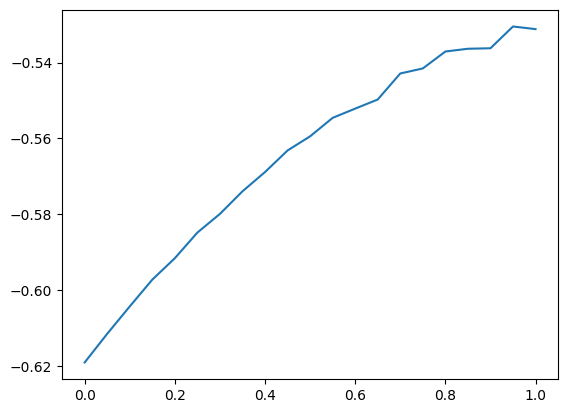

In [70]:
utility_sims = [arr.mean() for arr in x_pi_sims]

sns.lineplot(x=pis, y=utility_sims)

*I've been debugging my code for hours and I have absolutely no clue why this graph is my final answer. I know it is wrong, but I cannot figure out what exactly is wrong. I've checked my code extensively and my implementations are fine (only issue I noticed is simulating too many RVs).*

*At this point I've given up, and I'll accept that this is wrong. I'll probably come back to this in the future, but I am extremely busy this week, so I can't spend any more time on this question :(*

# Question 3

In [73]:
rng = np.random.default_rng(1234)

## (a)

We define the payoff

$$
\Phi (\{X_t\}_{[0, 0.5]}) = \begin{cases}
1 &\text{if } X_t \in [15, 25] \forall \, 0 \leq t \leq 0.5 \\
0 &\text{otherwise}
\end{cases}
$$

And set $dX_t = 0.04 X_t dt + 0.4 X_{t}^{0.8} dW_t, X_0 = 20$

In [74]:
num_points = int(0.5 / 0.01) + 1
M = int(1e5)

standard_start_time = time.time()
samples = np.empty((M, num_points))
samples[:, 0] = 20
dW = rng.normal(loc=0, scale=0.1, size=(M, num_points-1))

for i in range(num_points - 1):
    samples[:, i+1] = samples[:, i] + 0.04 * samples[:, i] * 0.01 + 0.4 * samples[:, i]**0.8 * dW[:, i]

in_corridor: np.ndarray = ((samples.max(axis=1) <= 25) & (samples.min(axis=1) >= 15)).astype(np.int8)

standard_end_time = time.time()
standard_time_elapsed = standard_end_time - standard_start_time

mc_mean = in_corridor.mean()
mc_se = in_corridor.std(mean=mc_mean) / np.sqrt(M)

print(f'Time Elapsed: {standard_time_elapsed} seconds')
print(f'95% Confidence Interval for Corridor Option: [{mc_mean - 1.96 * mc_se:.4f}, {mc_mean + 1.96 * mc_se:.4f}]')

Time Elapsed: 0.5876007080078125 seconds
95% Confidence Interval for Corridor Option: [0.8075, 0.8124]


## (b)

For the antithetic sampling method, we take $$-dW_t$$ and add these to our estimates.

In [75]:
antithetic_time_start = time.time()

antithetic_samples = np.empty((M, num_points))
antithetic_samples[:, 0] = 20
antithetic_dW = -dW

for i in range(num_points - 1):
    antithetic_samples[:, i+1] = antithetic_samples[:, i] + 0.04 * antithetic_samples[:, i] * 0.01 + 0.4 * antithetic_samples[:, i]**0.8 * antithetic_dW[:, i]

final_antithetic_samples = np.concatenate([samples, antithetic_samples])

antithetic_in_corridor: np.ndarray = ((final_antithetic_samples.max(axis=1) <= 25) & (final_antithetic_samples.min(axis=1) >= 15)).astype(np.int8)

antithetic_time_stop = time.time()
antithetic_time_elapsed = antithetic_time_stop - antithetic_time_start

antithetic_mc_mean = antithetic_in_corridor.mean()
antithetic_mc_se = antithetic_in_corridor.std(mean=antithetic_mc_mean) / np.sqrt(2 * M)

print(f'95% Antithetic Confidence Interval for Corridor Option: [{antithetic_mc_mean - 1.96 * antithetic_mc_se:.4f}, {antithetic_mc_mean + 1.96 * antithetic_mc_se:.4f}]')
print(f'Regular MC SE: {mc_se}', f'Antithetic MC SE: {antithetic_mc_se}', sep='\n')

95% Antithetic Confidence Interval for Corridor Option: [0.8082, 0.8117]
Regular MC SE: 0.0012407642548042718
Antithetic MC SE: 0.0008772821621348516


## (c)

I will use the step sizes $h_1 = 0.01$, $h_2 = 0.02$, $h_3 = 0.0025$. In doing so, the scheme in (a) becomes the cheap one, and we're incorporating benefits of faster schemes.

In [76]:
N1 = 50000
h1 = 0.01
N2 = 15000
h2 = 0.005
N3 = 5000
h3 = 0.0025

For ease, we recall $dX_t = 0.04 X_t dt + 0.4 X_{t}^{0.8} dW_t, X_0 = 20$.

Set $G_i$ to be scheme $i$ (i.e. using step size $h_i$). Then we are evaluating

$$
    \mathbb{E} [G_0] + \mathbb{E} [G_1 - G_0] + \mathbb{E} [G_2 - G_1]
$$

Where we simulate each item under the expectation independently.

In [77]:
mlmc_start_time = time.time()

# coarse scheme
coarse_points = int(0.5 / h1) + 1
coarse_x = np.empty((N1, coarse_points))
coarse_x[:, 0] = 20
coarse_dW = np.sqrt(h1) * rng.normal(size=(N1, coarse_points - 1))

for i in range(coarse_points - 1):
    prev_x = coarse_x[:, i]
    coarse_x[:, i+1] = prev_x + 0.04 * prev_x * h1 + 0.4 * prev_x**0.8 * coarse_dW[:, i]

coarse_payoffs: np.ndarray = ((coarse_x.max(axis=1) <= 25) & (coarse_x.min(axis=1) >= 15)).astype(np.int8)

# moderate scheme
moderate_points = int(0.5 / h2) + 1
moderate_x = np.empty((N2, moderate_points))
moderate_x[:, 0] = 20
moderate_bm = rng.normal(size=(N2, moderate_points - 1))
moderate_dW = np.sqrt(h2) * moderate_bm

for i in range(moderate_points - 1):
    prev_x = moderate_x[:, i]
    moderate_x[:, i+1] = prev_x + 0.04 * prev_x * h2 + 0.4 * prev_x**0.8 * moderate_dW[:, i]

moderate_level1_payoffs: np.ndarray = ((moderate_x.max(axis=1) <= 25) & (moderate_x.min(axis=1) >= 15)).astype(np.int8)

# use moderate RVs for coarse RVs
coarse_with_moderate_x = np.empty((N2, coarse_points))
coarse_with_moderate_x[:, 0] = 20
coarse_with_moderate_dW = np.sqrt(h2 / 2) * (moderate_bm[:, ::2] + moderate_bm[:, 1::2])

for i in range(coarse_points - 1):
    prev_x = coarse_with_moderate_x[:, i]
    coarse_with_moderate_x[:, i+1] = prev_x + 0.04 * prev_x * h1 + 0.4 * prev_x**0.8 * coarse_with_moderate_dW[:, i]

moderate_level0_payoffs: np.ndarray = ((coarse_with_moderate_x.max(axis=1) <= 25) & (coarse_with_moderate_x.min(axis=1) >= 15)).astype(np.int8)

moderate_bias = moderate_level1_payoffs - moderate_level1_payoffs

# fine scheme
fine_points = int(0.5 / h3) + 1
fine_x = np.empty((N3, fine_points))
fine_x[:, 0] = 20
fine_bm = rng.normal(size=(N3, fine_points - 1))
fine_dW = np.sqrt(h3) * fine_bm

for i in range(fine_points - 1):
    prev_x = fine_x[:, i]
    fine_x[:, i+1] = prev_x + 0.04 * prev_x * h3 + 0.4 * prev_x**0.8 * fine_dW[:, i]

fine_level2_payoffs: np.ndarray = ((fine_x.max(axis=1) <= 25) & (fine_x.min(axis=1) >= 15)).astype(np.int8)

# coarse scheme with fine BM
moderate_with_fine_x = np.empty((N3, moderate_points))
moderate_with_fine_x[:, 0] = 20
moderate_with_fine_dW = np.sqrt(h2 / 2) * (fine_bm[:, ::2] + fine_bm[:, 1::2])

for i in range(moderate_points - 1):
    prev_x = moderate_with_fine_x[:, i]
    moderate_with_fine_x[:, i+1] = prev_x + 0.04 * prev_x * h2 + 0.4 * prev_x**0.8 * moderate_with_fine_dW[:, i]

fine_level1_payoffs: np.ndarray = ((moderate_with_fine_x.max(axis=1) <= 25) & (moderate_with_fine_x.min(axis=1) >= 15)).astype(np.int8)

fine_bias = fine_level2_payoffs - fine_level1_payoffs

mlmc_end_time = time.time()
mlc_time_elapsed = mlmc_end_time - mlmc_start_time

In [78]:
# compute monte carlo estimates and se
# note that due to independence, se of final estimate is just sum of the se's 
mlmc_mean = coarse_payoffs.mean() + moderate_bias.mean() + fine_bias.mean()
mlmc_se = np.sqrt(coarse_payoffs.var() / N1 + moderate_bias.var() / N2 + fine_bias.var() / N3)

print(f'95% MLMC Confidence Interval: [{mlmc_mean - 1.96 * mlmc_se}, {mlmc_mean + 1.96 * mlmc_se}]')
print(
    f'Standard SE: {mc_se}, Time Elapsed: {standard_time_elapsed}',
    f'Antithetic SE: {antithetic_mc_se}, Time Elapsed: {antithetic_time_elapsed}',
    f'MLMC SE: {mlmc_se}, Time Elapsed: {mlc_time_elapsed}',
    sep='\n'
)

95% MLMC Confidence Interval: [0.7987142847888962, 0.8068057152111039]
Standard SE: 0.0012407642548042718, Time Elapsed: 0.5876007080078125
Antithetic SE: 0.0008772821621348516, Time Elapsed: 0.6238477230072021
MLMC SE: 0.002064140413828478, Time Elapsed: 0.4974968433380127


In [79]:
print(f'Percent Change for Standard Error: {100 * (mlmc_se - mc_se) / mc_se:.4f}%')
print(f'Percent Change for Time Elapsed: {100 * (mlc_time_elapsed - standard_time_elapsed) / standard_time_elapsed:.4f}%')

Percent Change for Standard Error: 66.3604%
Percent Change for Time Elapsed: -15.3342%


Compared to Standard Monte Carlo, we see that MLMC achieves 66.4% more error while running 15.3% faster.